# **EEC 174AY Lab 2: Supervised Learning**


## **Outline**

1. Basics of Python Pandas for Reading & Manipulating Data
    - Assignment #1
2. Introduction to Scikit-Learn (package used for more traditional machine learning tools), create an RF model
    - Assignment #2
    - Assignment #3
3. Improving your model: Feature Selection
    - Assignmnet #4
    - Assignment #5
4. K-Fold Validation
    - Assignment #6

# **1. Basics of Python Pandas for Reading & Manipulating Data**

### **1.1: Reading Data into Memory**

For this lab, we will be looking at ventilator data of patients' breath patterns. We will be working with *train x* and *train y* datasets to train a model. Then, we will use *test x* and *test y* datasets to validate our model.

First, let's load in our data:

In [1]:
# make sure we can plot in future if we want
# %matplotlib notebook
# make sure to ignore warnings
import warnings
warnings.simplefilter('ignore')
# Import statement for pandas
import pandas as pd
# This is just a small configuration change for purposes of the class
pd.options.display.max_rows = 10

# Get our train X and y datasets for the problem
train_x = pd.read_csv('ece174_pva_train_x.csv')
train_y = pd.read_csv('ece174_pva_train_y.csv')

# Get our validation X and y datasets for the problem.
test_x = pd.read_csv('ece174_pva_validation_x.csv')
test_y = pd.read_csv('ece174_pva_validation_y.csv')

In [2]:
# output some rows of the dataset just to get a better feel for the information
train_x

,breath_id,i_time,tve,max_flow,min_flow,max_pressure,peep,ip_auc,ep_auc,patient
0,1,0.80,545.032222,51.06,-41.03,17.37,7.600,11.122367,16.057733,66
1,2,0.80,531.880278,53.13,-39.97,17.13,7.508,11.077750,17.310533,66
2,3,0.86,523.876667,52.86,-38.24,17.11,7.658,12.066000,16.697800,66
3,4,0.80,507.636111,51.04,-39.37,17.14,7.572,11.097800,15.774250,66
4,5,0.80,518.618889,47.88,-38.51,16.92,7.598,11.065400,18.483333,66
...,...,...,...,...,...,...,...,...,...,...
5970,296,0.90,355.365278,42.26,-51.51,23.53,13.194,19.216400,21.816367,662
5971,297,0.90,316.806944,42.10,-55.17,24.61,12.896,19.800467,21.739700,662
5972,298,0.92,395.971111,42.95,-22.47,21.35,13.090,16.997767,21.457600,662
5973,299,0.90,373.426389,40.34,-36.81,21.69,13.334,17.944000,21.798167,662


**Features**

The data currently has 10 columns above. Later in Assignment 1 you will increase these to 18. Below is a description of all 18 columns or *features*. Note that some column information cannot be featurized such as `patient` or `breath_id`.

 * `breath_id`: matches with a specific breath identifier from the raw data file.
 * `patient`: the patient the data came from
 * `min_flow`: The minimum flow observation on the breath
 * `max_flow`: The maximum flow observation on the breath
 * `tvi`: The inhaled volume of air for each breath
 * `tve`: The exhaled volume of air for each breath
 * `tve_tvi_ratio`: The ratio of `tve / tvi`
 * `i_time`: The amount of time patient was breathing in for each breath
 * `e_time`: The amount of time patient was breathing out for each breath
 * `ie_ratio`: The ratio of `i_time / e_time`
 * `rr`: The respiratory rate in number of breaths per minute. Measured by `60 / (i_time + e_time)`
 * `min_pressure`: the minimum pressure observation on the breath
 * `max_pressure`: the maximum pressure observation on the breath
 * `peep`: - the baseline pressure setting on the ventilator
 * `pip`: the maximum pressure setting of inspiration. Slight difference compared to max_pressure
 * `maw`: the mean pressure for the entire breath
 * `ip_auc`: the area under the curve of the inspiratory pressure
 * `ep_auc`: the area under the curve of the expiratory pressure

### **1.2: Featurization**

Featurization is the process where you extract information from raw data. This information can then be fed into a machine learning algorithm to perform the task you want. In the current case we will need to extract additional information from the ventilator data in order to create a valid machine learning classifier.

#### Processing the Data
The first step we need to do is to be able to read the raw data files and put them into memory.

Here, we load in the ventilator data stored in the patient CSV files and organize them by breath cycles.

In [3]:
import csv


def process_ventilator_data(filename):
    descriptor = open(filename)
    reader = csv.reader(descriptor)
    breath_id = 1

    all_breath_data = []
    current_flow_data = []
    current_pressure_data = []

    for row in reader:
        if (row[0].strip() == 'BS' or row[0].strip() == 'BE') and current_flow_data != []:
            all_breath_data.append({'breath_id': breath_id, 'flow': current_flow_data, 'pressure': current_pressure_data})
            breath_id += 1
            current_flow_data = []
            current_pressure_data = []
        else:
            try:
                current_flow_data.append(round(float(row[0]), 2))
                current_pressure_data.append(round(float(row[1]), 2))
            except (IndexError, ValueError):
                continue
    return all_breath_data

Now that we have the capability to read ventilator data into memory, we should try to visualize what the data looks like.
We will be extracting just one breath cycle to visualize the breath flow and pressure of the patient.

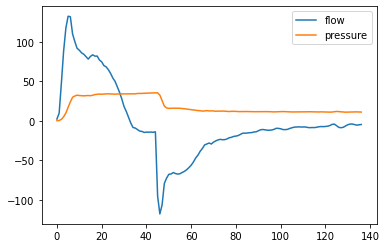

In [4]:
import os
from glob import glob

import matplotlib.pyplot as plt

data_files = glob(os.path.join('data', '*/*.csv'))
example_file = data_files[0]
breath_data = process_ventilator_data(example_file)
flow = breath_data[0]['flow']
pressure = breath_data[0]['pressure']
plt.plot(flow, label='flow')
plt.plot(pressure, label='pressure')
plt.legend()
plt.show()

## **Assignment \#1: Featurization**

Now that we've visualized the data we need to featurize the data so we can use it in a ML algorithm. We'll need a bit more code to do this. We've already given you 10 features above that you can use for the current models. Your assignment will be to process the rest of the 8 features based on the requirements and hints that I've given in the code below.

In [5]:
from glob import glob
import os

# import for Simpson's method. This will be helpful for calculating TVi
from scipy.integrate import simps
from statistics import mean


def extract_features_for_file(filename, existing_features):
    """
    Extract features for every single breath in file. To make matters a bit easier, we use
    existing features that we've already extracted from the file to help speed the process.
    """
    patient = filename.split('/')[-2]
    all_breath_data = process_ventilator_data(filename)
    all_features = []

    for breath_data in all_breath_data:
        breath_id = breath_data['breath_id']
        existing_breath_features = existing_features[existing_features.breath_id == breath_id].iloc[0]

        flow = breath_data['flow']
        pressure = breath_data['pressure']

        # inspiratory time (the amount of time a patient is inhaling for)
        i_time = existing_breath_features.i_time
        # exhaled tidal volume
        tve = existing_breath_features.tve
        # maximum flow for breath
        max_flow = existing_breath_features.max_flow
        # minimum flow for the breath
        min_flow = existing_breath_features.min_flow
        # maximum pressure for the breath
        max_pressure = existing_breath_features.max_pressure
        # The minimum pressure setting on the ventilator
        peep = existing_breath_features.peep
        # The area under the curve of the inspiratory pressure curve
        ip_auc = existing_breath_features.ip_auc
        # The area under the curve of the expiratory pressure curve
        ep_auc = existing_breath_features.ep_auc

        # This is the array index where the inhalation ends. We divide by 0.02 because
        # thats how frequently the ventilator samples data, every 0.02 seconds.
        x0_index = int(i_time / 0.02)

        # Part of your assignment is to extract the following features for all breaths:
        #
        # Expiratory Time. The amount of time a patient is exhaling
        # time unit: second
        e_time = len(flow) * 0.02 - i_time
        
        #
        # I:E ratio. The ratio of inspiratory to expiratory time. Measured by i_time/e_time
        i_e_ratio = i_time / e_time 

        #
        # Respiratory rate. The number of breaths a patient is breathing. This is measured by
        # 60 / (total breath time in seconds)
        rr = 60 / (i_time + e_time)

        #
        # Tidal volume inhaled. The amount of air volume inhaled in the breath.
        # Hint: use the simps function.
        # This will output volume in L/min, convert to ml/sec (* 1000 / 60)
        tvi = simps(flow[:x0_index]) * 1000 / 60

        #
        # Tidal volume ratio. Measured by tve/tvi
        tve_tvi_ratio = tve / tvi

        #
        # Minimum pressure of the breath
        min_pressure = min(pressure)

        #
        # PIP - peak inspiratory pressure. The peak pressure during inhalation
        pip = max(pressure[:x0_index])

        #
        # MAW - mean airway pressure for inhalation.
        maw = mean(pressure[:x0_index])


        all_features.append([
            breath_id, i_time, e_time, i_e_ratio, rr, tvi, tve, tve_tvi_ratio,
            max_flow, min_flow, max_pressure, min_pressure, pip, maw,
            peep, ip_auc, ep_auc, int(patient)
        ])
    columns = [
        'breath_id', 'i_time', 'e_time', 'i_e_ratio', 'rr', 'tvi', 'tve',
        'tve_tvi_ratio', 'max_flow', 'min_flow', 'max_pressure',
        'min_pressure', 'pip', 'maw', 'peep', 'ip_auc', 'ep_auc', 'patient'
    ]
    return all_features, columns


In [6]:
def remake_dataset(dataset):
    data_files = glob(os.path.join('data', '*/*.csv'))

    patient_to_file_map = {}
    for filename in data_files:
        patient = filename.split('/')[-2]  # patient is embedded in this part of filename
        patient_to_file_map[patient] = filename

    data = []
    # iterate over all the unique patients in the train set
    for patient in dataset.patient.unique():
        existing_features = dataset[dataset.patient == patient]
        filename = patient_to_file_map[str(patient)]
        breath_data, columns = extract_features_for_file(filename, existing_features)
        # add breath rows
        data.extend(breath_data)
    # create new data frame with the new added information
    return pd.DataFrame(data, columns=columns)

In [7]:
# remake train set
train_x = remake_dataset(train_x)
# remake validation set.
test_x = remake_dataset(test_x)

In [8]:
train_x

,breath_id,i_time,e_time,i_e_ratio,rr,tvi,tve,tve_tvi_ratio,max_flow,min_flow,max_pressure,min_pressure,pip,maw,peep,ip_auc,ep_auc,patient
0,1,0.80,1.66,0.481928,24.390244,24096.152778,545.032222,0.022619,51.06,-41.03,17.37,7.04,17.37,14.208500,7.600,11.122367,16.057733,66
1,2,0.80,1.80,0.444444,23.076923,24235.625000,531.880278,0.021946,53.13,-39.97,17.13,7.04,17.13,14.149500,7.508,11.077750,17.310533,66
2,3,0.86,1.74,0.494253,23.076923,26068.500000,523.876667,0.020096,52.86,-38.24,17.11,7.04,17.11,14.311860,7.658,12.066000,16.697800,66
3,4,0.80,1.64,0.487805,24.590164,24196.069444,507.636111,0.020980,51.04,-39.37,17.14,7.04,17.14,14.174500,7.572,11.097800,15.774250,66
4,5,0.80,1.94,0.412371,21.897810,23314.680556,518.618889,0.022244,47.88,-38.51,16.92,7.04,16.92,14.131250,7.598,11.065400,18.483333,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5970,296,0.90,1.60,0.562500,24.000000,17484.111111,355.365278,0.020325,42.26,-51.51,23.53,13.00,23.53,21.750667,13.194,19.216400,21.816367,662
5971,297,0.90,1.60,0.562500,24.000000,17506.500000,316.806944,0.018097,42.10,-55.17,24.61,12.80,24.61,22.414667,12.896,19.800467,21.739700,662
5972,298,0.92,1.58,0.582278,24.000000,17722.166667,395.971111,0.022343,42.95,-22.47,21.35,12.90,21.35,18.785435,13.090,16.997767,21.457600,662
5973,299,0.90,1.60,0.562500,24.000000,16897.055556,373.426389,0.022100,40.34,-36.81,21.69,13.02,21.69,20.308444,13.334,17.944000,21.798167,662


# **2. Introduction to Scikit-Learn**

### **2.1: Create Ground Truth**

We will use the corresponding *test y* dataset containing healthy non-PVA, Breath Stacking Asynchrony (bsa), and Double Trigger Asynchrony (dta) labels as the ground truth for training our model.

In [9]:
# Read the test dataset and set it up.
test_y

,breath_id,patient,bsa,dta,cough,suction
0,20,292,1,0,0,0
1,21,292,1,0,0,0
2,22,292,0,0,0,0
3,23,292,1,0,0,0
4,24,292,1,0,0,0
...,...,...,...,...,...,...
1242,295,114,0,0,0,0
1243,296,114,0,0,0,0
1244,297,114,0,0,0,0
1245,298,114,0,0,0,0


What does this mean?

We have 6 columns here
 * `breath_id`: matches with a specific breath identifier from the raw data file.
 * `patient`: the patient the data came from
 * `bsa`: Breath Stacking Asynchrony. A single breath where the patient is trapping air in their chest
 * `dta`: Double Trigger Asynchrony. Two breaths in a row where the patient is trapping air
 * `cough`: What it sounds like, when a patient coughs
 * `suction`:  Nurses perform suction procedures to remove excess fluid from an endotracheal tube. This waveform is indicative of that.

 Each patient will either have healthy breath pattern, breath stacking asynchrony, or double trigger asynchrony, indicated by which label is 1 or 0.

Now that we understand what our columns are, we need to put it into a format where the machine can understand it and create a learning model. Because this is a multiclass model, let's just have *non-PVA breaths* be class 0, *breath stacking* can be class 1, *double trigger* can be class 2.

In [10]:
# Create a multi-class y vector that we can use for training purposes.
train_y_vector = train_y.bsa * 1 + train_y.dta * 2
test_y_vector = test_y.bsa * 1 + test_y.dta * 2
test_y_vector

0       1
1       1
2       0
3       1
4       1
       ..
1242    0
1243    0
1244    0
1245    0
1246    0
Length: 1247, dtype: int64

Therefore, there will be only three categories in our dataset (non-PVA, bsa, dta).

### **2.2: Create and train a Random Forest Classifier**

Let's finalize the dataset and remove misannotated examples first.

In [11]:
# See if there places where the data was mis-annotated, where both double trigger and breath stack was annotated.
# It's just good to know if this is happening or not so that we can either drop the data, or change it later on.
train_y_vector[train_y_vector > 2]

5438    3
5440    3
5521    3
dtype: int64

In [12]:
# Mark places where data is double annotated.
misannotated_train = train_y_vector > 2
misannotated_test = test_y_vector > 2

# Drop data flagged above (~ is the NOT operator)
train_x = train_x.loc[~misannotated_train]
train_y_vector = train_y_vector.loc[~misannotated_train]

# do same thing for test
test_x = test_x.loc[~misannotated_test]
test_y_vector = test_y_vector.loc[~misannotated_test]

Let's also remove data that is NaN. This is very important because otherwise your model won't train.

In [13]:
'''
The .any(axis=1) function basically says, if there are any NaNs in this *ROW* then mark the row as true.
The .any(axis=0) would mark columns as True/False, but this isn't helpful now.
'''

nans_train = train_x.isna().any(axis=1)
nans_test = test_x.isna().any(axis=1)

# now filter them out of the dataset in the same way
train_x = train_x.loc[~nans_train]
train_y_vector = train_y_vector.loc[~nans_train]

test_x = test_x.loc[~nans_test]
test_y_vector = test_y_vector.loc[~nans_test]

Any time we drop things from a data frame or series in pandas it is often helpful to re-index the object.
The index is usually a sequential ordering of the rows like 1, 2, ... n. Sometimes it can be different
but for now we'll just use sequential ordering.

In [14]:
train_x.index = range(len(train_x))
train_y_vector.index = range(len(train_y_vector))

test_x.index = range(len(test_x))
test_y_vector.index = range(len(test_y_vector))

Now we can train the model.

In [15]:
from sklearn.ensemble import RandomForestClassifier

# initialize model
model = RandomForestClassifier()

# don't use patient and breath_id columns
columns_to_use = list(set(train_x.columns).difference(['patient', 'breath_id']))

# fit the model to training
model.fit(train_x[columns_to_use], train_y_vector)

# Now that the model is fitted, evaluate how well it is performing
predictions = model.predict(test_x[columns_to_use])


'''
The optimization below helps re-model the data in the train set slightly so that the first double
trigger breath in training set is marked as a breath stack, and kept last double trigger breath a double trigger.
You don't not need to understand this part of the code.
'''


for idx, pred in enumerate(predictions):
    if pred == 2:
        predictions[idx-1] = 2

To evaluate our model, we can use `sklearn.metrics` from *scikit-learn*, since PyTorch doesn't have a built-in metrics module. The `classification_report()` function provides key stats like precision, recall, and F1 score, making it useful for quickly assessing performance, especially with multiple classes.

In [16]:
from sklearn.metrics import classification_report

print(classification_report(test_y_vector, predictions))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       842
           1       0.86      0.96      0.91       301
           2       1.00      0.04      0.07       104

    accuracy                           0.89      1247
   macro avg       0.92      0.66      0.64      1247
weighted avg       0.90      0.89      0.85      1247



### **2.3 Scaling for ML**
Scaling data is often essential, especially for neural networks, and can improve performance in models like random forests. Common methods include:

#### **2.3.1: Standardization**
Standardization transforms data by subtracting the mean and dividing by the standard deviation:
$$ \frac{x_f - \mu_f}{\sigma_f} $$
Where $x_f$ is the feature, $\mu_f$ is the mean, and $\sigma_f$ is the standard deviation. Scikit-Learn simplifies this:

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)
```

#### **2.3.2 Min-Max Scaling**
This method scales features to a [0, 1] range:

$$ (x_f - min(x_f)) \div (max(x_f) - min(x_f)) $$

Where the `min` function is just finding the minimum value of a feature vector, and the `max` function is finding the maximum value of a feature vector. You can do this quickly in Scikit-Learn too.

```python
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)
```

#### **2.3.3 Robust Scaler**
The robust scaler removes the median and scales by the interquartile range (IQR), making it effective for data with outliers. It's worth experimenting with different scalers to see what works best for your model.

```python
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
train_set_scaled = scaler.fit_transform(train_set)
test_set_scaled = scaler.transform(test_set)
```

## **Assignment \#2: Create a working model of a random forest classifier with all the features given.**

If you've been able to featurize all your information correctly, let's move onto creating a random forest model for the completely featurized dataset. You **must** use one of the scaling strategies. Run your model 10 times to get performance scores for precision, recall, and f1-score. Average and report the results **per class**.

In [17]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# Function to train our model and is run 10 times
def trainset(train_x_scaled, train_y_vector, test_x_scaled, test_y_vector, runs=10):

#making our initialized values that will store our important scores 
    precision_scores = {0: [], 1: [], 2: []}
    recall_scores = {0: [], 1: [], 2: []}
    f1_scores = {0: [], 1: [], 2: []}

    model = RandomForestClassifier()

#loop to train the model and use the code earlier in the lab to fit and make prediction along with the optimization
    for _ in range(runs):

        # fit the model to training
        model.fit(train_x_scaled, train_y_vector)

        # Now that the model is fitted, evaluate how well it is performing
        predictions = model.predict(test_x_scaled)

        for idx, pred in enumerate(predictions):
            if pred == 2:
                predictions[idx-1] = 2

        # testing using precision, recall, and f1-score
        precision, recall, f1, _ = precision_recall_fscore_support(test_y_vector, predictions, labels=[0, 1, 2])

        #This loop goes over each class (0, 1, 2), and appends the data
        for i, label in enumerate([0, 1, 2]):  
            precision_scores[label].append(precision[i])
            recall_scores[label].append(recall[i])
            f1_scores[label].append(f1[i])

    return precision_scores, recall_scores, f1_scores

# Running the model 10 times
precision_scores, recall_scores, f1_scores = trainset(train_x_scaled, train_y_vector, test_x_scaled, test_y_vector, runs=10)


#getting the averages 
avg_precision = {label: np.mean(scores) for label, scores in precision_scores.items()}
avg_recall = {label: np.mean(scores) for label, scores in recall_scores.items()}
avg_f1 = {label: np.mean(scores) for label, scores in f1_scores.items()}

#printing our data, i chose to do it just like the slide and added the .16f to output all decimal points
for label in [0, 1, 2]:
    print(f"Class {label} precision: {avg_precision[label]:.16f}")
    print(f"Class {label} recall: {avg_recall[label]:.16f}")
    print(f"Class {label} f1-score: {avg_f1[label]:.16f}")


Class 0 precision: 0.9005479537609509
Class 0 recall: 0.9614014251781473
Class 0 f1-score: 0.9299789702466403
Class 1 precision: 0.8456141364617858
Class 1 recall: 0.9661129568106313
Class 1 f1-score: 0.9018500733996854
Class 2 precision: 0.9500000000000000
Class 2 recall: 0.0365384615384615
Class 2 f1-score: 0.0691059368352797


## **Assignment #3: Comparison of Supervised ML Algorithms**

In machine learning, much focus is placed on choosing the right algorithm. However, trying a different algorithm doesn’t always improve performance and can sometimes complicate things. That said, it's important to explore different models that fit your problem.

In this assignment, you need to implement *at least one* Supervised Learning model and compare its performance with the Random Forest model. Report metrics such as misclassification rate, precision, recall, F1-score, etc.

### **Supervised Learning Algorithms to Consider:**
- Neural Networks (use PyTorch/TensorFlow if preferred)
- Logistic Regression
- Naive Bayes
- SVM (typically for binary classification but can be explored for multi-class)
- etc.

Hints:
### Logistic Regression

Now we’ll run L1-regularized logistic regression on our dataset.
You may use:
```python
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
```
* Fit a L1-regularized logistic regression model by letting python chose the regularization
parameter itself.

Hint:
```python
model = LogisticRegression(penalty='l1') # L1-regularized
```

### kNN Classifier

Use kNN classifier model on our dataset.

```python
from sklearn.neighbors import KNeighborsClassifier
```


In [18]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Initialize the scaler using only the columns that were specified earlier in columns_to_use
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x[columns_to_use])
test_x_scaled = scaler.transform(test_x[columns_to_use])

# im using the kNN Classifier
def trainknn(train_x_scaled, train_y_vector, test_x_scaled, test_y_vector, k=5):

    # Initialize kNN model
    model = KNeighborsClassifier(n_neighbors=k)
    
     # fit the model to training
    model.fit(train_x_scaled, train_y_vector)

    # evaluate it
    predictions = model.predict(test_x_scaled)

    # calculates precision, recall, F1-score for each
    precision, recall, f1, _ = precision_recall_fscore_support(test_y_vector, predictions, labels=[0, 1, 2])
    
    # calculates the overall accuracy
    accuracy = accuracy_score(test_y_vector, predictions)

    return precision, recall, f1, accuracy

#  function is called with the scaled training and test data, and k=5
knn_precision, knn_recall, knn_f1, knn_accuracy = trainknn(train_x_scaled, train_y_vector, test_x_scaled, test_y_vector, k=5)

# Report the results using the k=5
print(f"kNN Classifier Results (k=5):")
print(f"  Accuracy: {knn_accuracy:.4f}")

for label in [0, 1, 2]:
    print(f"  Class {label} precision: {knn_precision[label]:.4f}")
    print(f"  Class {label} recall: {knn_recall[label]:.4f}")
    print(f"  Class {label} f1-score: {knn_f1[label]:.4f}")


kNN Classifier Results (k=5):
  Accuracy: 0.6728
  Class 0 precision: 0.8416
  Class 0 recall: 0.7067
  Class 0 f1-score: 0.7682
  Class 1 precision: 0.5295
  Class 1 recall: 0.7741
  Class 1 f1-score: 0.6289
  Class 2 precision: 0.1100
  Class 2 recall: 0.1058
  Class 2 f1-score: 0.1078


# **3. Feature Selection**

We know there are only 3 classes in our labels as shown below.

In [19]:
test_y

,breath_id,patient,bsa,dta,cough,suction
0,20,292,1,0,0,0
1,21,292,1,0,0,0
2,22,292,0,0,0,0
3,23,292,1,0,0,0
4,24,292,1,0,0,0
...,...,...,...,...,...,...
1242,295,114,0,0,0,0
1243,296,114,0,0,0,0
1244,297,114,0,0,0,0
1245,298,114,0,0,0,0


One thing to note is that we are using 16 different features for input into our model. Some of these features can be of little value to classifying whether a breath is asynchronous or not. So, one of the easiest things we can do for ourselves is to reduce the number of features that we have in an intelligent way.

### **3.1: $\chi^2$ Feature Selection** (chi squared)

The chi-squared (χ²) test is an intuitive method for feature selection in classification problems. It evaluates whether a feature is independent of the target variable—if so, the feature may not be useful for the model. A high χ² value with a low p-value (≤ 0.05) suggests that the feature is dependent on the outcome.

Learn more about the chi-squared test on [Wikipedia](https://en.wikipedia.org/wiki/Chi-squared_test) and its application in [feature selection](https://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).


[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html) provides a function for performing the χ² test.

In [20]:
# this is the PrettyPrint function. Just makes things look a bit nicer on output.
from pprint import pprint

from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

# get all columns in our dataset except patient and breath_id
columns_to_use = list(set(train_x.columns).difference(['patient', 'breath_id']))

# must scale feature vectors so they are non-negative
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_x[columns_to_use])

# the chi2 test will output two things, chi2 and p values. The p values are the most relevant item that we want
# to use. A feature with a p-value between 0 and 0.05 means that a feature might be a good predictor of our outcome.
chi2_vals, pvals = chi2(train_set, train_y_vector)

# mash column names with p-values so we know which p-value belongs to which feature
cols_to_pvals = zip(pvals, columns_to_use)
# Sort the p-values in ascending order (smallest first).
cols_sorted = sorted(cols_to_pvals)
# pretty print the sorted values.
print(cols_sorted)

[(2.0845956610565352e-15, 'ep_auc'), (4.1963626094156816e-10, 'tve'), (8.032273135835149e-06, 'e_time'), (9.867120183960791e-06, 'i_e_ratio'), (0.0064789968190118105, 'rr'), (0.018753422526064954, 'i_time'), (0.056752121480488624, 'ip_auc'), (0.15346609771450018, 'max_pressure'), (0.4176834544812468, 'min_flow'), (0.45399781936316896, 'peep'), (0.5040246270526789, 'pip'), (0.6017652297121289, 'maw'), (0.6801265398971335, 'max_flow'), (0.8455385940418909, 'tvi'), (0.9029585211862035, 'min_pressure'), (0.9987987662938473, 'tve_tvi_ratio')]


There are 2 features that had p-values below 0.05:

 * tve
 * ep_auc

So let's use these features for our next model.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

model = RandomForestClassifier()
columns_to_use = ['tve', 'ep_auc']

scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_x[columns_to_use])
test_set = scaler.transform(test_x[columns_to_use])

model.fit(train_set, train_y_vector)
predictions = model.predict(test_set)
for idx, pred in enumerate(predictions):
    if pred == 2:
        predictions[idx-1] = 2

print(classification_report(test_y_vector, predictions))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       842
           1       0.38      0.48      0.43       301
           2       0.12      0.02      0.03       104

    accuracy                           0.64      1247
   macro avg       0.42      0.42      0.41      1247
weighted avg       0.61      0.64      0.62      1247



Our performance dropped when using the χ² test. Does this mean the method isn't suitable for our problem?

**What's happening?**

Although the χ² test indicates certain features are relevant, they may not generalize well to the test set. This is common in machine learning—features important in training don't always perform well in testing. Are there other feature selection methods that may generalize better?

### **3.2: Expert Feature Selection**

Expert knowledge, such as medical insights, can improve model performance. What medical knowledge can we use here?

#### **3.2.1: Breath Stack (BSA)**
When a patient traps air in their chest, it can be measured by the `tve_tvi_ratio`. Doctors annotated breaths with a `tve_tvi_ratio < .9`, excluding suction/cough or anomalies.

<img src="bsa-breath.png" alt="Drawing" style="width: 400px;"/>

#### **3.2.2: Double Trigger (DTA)**
Double trigger has a double-hump waveform pattern.

<img src="dta-breaths.png" alt="Drawing" style="width: 600px;"/>

Doctors annotated it as:

1. Not an anomaly
2. First breath with `e_time < .3` seconds
3. First breath with `tve_tvi_ratio < .25` or `0.25 <= tve_tvi_ratio < 0.5` and `tve < 100`

## **Assignment \#4a: Expert Feature Selection**

Using the expert features above, write a function to give predictions on the train set.
Then, create a classification report on your predictions.

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# features from First breath with e_time < .3 seconds first breath with tve_tvi_ratio < .25 or 0.25 <= tve_tvi_ratio < 0.5 and tve < 100
columns_to_use = ['tve_tvi_ratio', 'tve', 'e_time']

scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_x[columns_to_use])
test_set = scaler.transform(test_x[columns_to_use])

model = RandomForestClassifier()

# fit the model on the training set
model.fit(train_set, train_y_vector)

# make predictions
predictions = model.predict(test_set)

#optimization
for idx, pred in enumerate(predictions):
    if pred == 2:
        predictions[idx-1] = 2

print("Classification Report\n")
print(classification_report(test_y_vector, predictions))


Classification Report

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       842
           1       0.82      0.98      0.89       301
           2       0.50      0.02      0.04       104

    accuracy                           0.89      1247
   macro avg       0.75      0.65      0.62      1247
weighted avg       0.86      0.89      0.85      1247



### **3.3: Other Feature Selection Methods**

You can explore various methods for feature selection. Here’s a brief overview:


#### **3.3.1: Wrapper Methods**
This brute-force approach trains models with all possible feature combinations and selects the best based on performance on the validation set.

**Pros:**
 * Easy to understand and code
 * Works with any model

**Cons:**
 * Prone to overfitting
 * Time-consuming—requires training $n!$ models for $n$ features


#### **3.3.2: PCA (Principal Component Analysis)**
[PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) transforms data into new, uncorrelated features. You choose the number of features, then train and evaluate models.

**Pros:**
 * Speeds up model training through dimensionality reduction
 * Features are linearly uncorrelated
 * Easy to use with libraries like [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Cons:**
 * Potential loss of information, which can reduce performance
 * Features lose interpretability


#### **3.3.3: Mutual Information**
[Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) measures the dependency between a feature and the target. A higher value indicates greater dependency.

**Pros:**
 * Fast
 * Supported by [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html)

**Cons:**
 * Like χ², it may not generalize to the test set

#### **3.3.4: Mixed Methods**
Combining methods is common. Start with expert feature selection, then add synthetic methods. Test different approaches, but be cautious of overfitting. Always evaluate using a solid validation set, not the test set.

## **Assignment \#4b (BONUS, not graded): Finish Expert Feature Selection & Find another Feature Selection Method to Use.**

Finish the coding for expert feature selection and use another feature selection method like PCA/mutual information/wrapper methods for use in your model. Which one performs best?

In [23]:
# YOUR CODE HERE

# **4. K-Fold Cross Validation: Systematically evaluating your model**

K-fold cross-validation is a resampling procedure used to systematically evaluate machine learning models. The procedure has a parameter called k that refers to the number of groups that a given data sample is to be split into. This technique is important in machine learning because it ensures that every observation from the original dataset has the chance of appearing in the training and test set, providing a thorough assessment of how well a model performs across different subsets of data.

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

## Define k
k = 3

## Initialize k-fold setup for cross-validation
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Model
model = RandomForestClassifier()

# Running through folds
for train_index, val_index in kf.split(train_x[columns_to_use], train_y_vector):
    
    # Use iloc for integer-location indexing
      X_train, X_test = train_x[columns_to_use].iloc[train_index], train_x[columns_to_use].iloc[val_index]
      y_train, y_test = train_y_vector.iloc[train_index], train_y_vector.iloc[val_index]

      # Now we can fit the model, generate predictions, and compare the performance with validation labels y_val.
      # Once that is done, we save the results for next fold/iteration


## **Assignment \#6: Perform k-fold cross-validation**

Evaluate an ML model of your choosing (Logistic Regression, etc...) under 5-fold cross-validation. Print the macro average precision, recall, and f1-scores in each fold. Print the average values across all 5 folds at the end of the loop. If you prefer, you can use sklearn's `precision_score()`, `recall_score()`, `f1_score()` instead of `classification_report()`. Please use random state 42.

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

#same features
columns_to_use = ['tve_tvi_ratio', 'tve', 'e_time', 'ep_auc', 'i_time', 'i_e_ratio']

## Initialize k-fold setup for cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Doing the Logistic Regression model
model = LogisticRegression(random_state=42)

precision_scores = []
recall_scores = []
f1_scores = []

# Loop through the 5 folds
for fold, (train_index, val_index) in enumerate(kf.split(train_x[columns_to_use], train_y_vector), 1):  # start fold from 1
    
# using the .iloc just like the TA said
    X_train, X_val = train_x[columns_to_use].iloc[train_index], train_x[columns_to_use].iloc[val_index]
    y_train, y_val = train_y_vector.iloc[train_index], train_y_vector.iloc[val_index]
    
    # fit the model
    model.fit(X_train, y_train)
    
    # make predictions
    y_pred = model.predict(X_val)
    
    # used macro average due to it giving each class the same importance regardless of its size.
    precision = precision_score(y_val, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_val, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_val, y_pred, average='macro', zero_division=0)
    
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
#make our print statements look like the ones in the slide
    print(f"Fold #{fold} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)

print(f"\nAverage Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1:.4f}")


Fold #1 - Precision: 0.7843, Recall: 0.5895, F1-Score: 0.6467
Fold #2 - Precision: 0.8064, Recall: 0.5745, F1-Score: 0.6370
Fold #3 - Precision: 0.7898, Recall: 0.5369, F1-Score: 0.5918
Fold #4 - Precision: 0.7973, Recall: 0.5983, F1-Score: 0.6587
Fold #5 - Precision: 0.7986, Recall: 0.5602, F1-Score: 0.6164

Average Precision: 0.7953
Average Recall: 0.5719
Average F1-Score: 0.6301


**Q: In the tutorial, you are taught to use the function StratifiedKFold. What does it mean when we stratify our k-folds?**

In [ ]:
It means that the folds are created so that they maintain the number of samples of each class in the data. This make it that 
each fold has a similar distribution of classes as the original dataset. Doing the normal k-fold makes the data split randomly
into subsets without considering the class labels, but doing the k-fold confirms that each fold contains approximately 
the same proportion of samples from each class as in the entire dataset.